# DataDetective
> *Crime classification and prediction tool for predictive policing.*
---
This notebook contains the code required to build a machine learning model along with all the data pre-processing steps

## Importing the libraries

We're going to use some python libraries to accomplish various tasks. To use these libraries we first have to import them using the following lines of code. We have imported Numpy and Pandas for loading and manipulating data. We have then imported matplotlib and seaborn for plotting figures and Sci-Kit Learn and Joblib to implement machine learning models and exporting or downloading the model respectively.

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
%matplotlib inline
import joblib
import folium
from folium.plugins import HeatMap
import plotly.graph_objects as go
import plotly.express as px
pd.set_option('display.max_rows', None)
import datetime
from plotly.subplots import make_subplots
from google.colab import files
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

## Loading the data
We are now ready to load our data using panda's `read_csv()` function.

In [ ]:
# Reading the csv files.
dataset=pd.read_csv('crime(new).csv')
data=pd.read_csv('crime(new).csv')

## Preprocessing of data
In our data set, there are NA values and an OCCURRED_ON_DATE column. The OCCURRED_ON_DATE column has a string format of 2018-02-28 21:00:00 which is why we have to convert it into datetime format usnig panda's `to_datetime()` function. Once we are done we will drop the rows with NA values and some unwanted columns. Once this is done we're good to go ahead.


In [15]:
# Keep only data on UCR Part One offenses
data = data.loc[data['UCR_PART'] == 'Part One']

# Remove unused columns
data = data.drop(['INCIDENT_NUMBER','UCR_PART','Location','SHOOTING','OFFENSE_DESCRIPTION','DISTRICT','REPORTING_AREA','STREET','OFFENSE_CODE'], axis=1)

# Convert OCCURED_ON_DATE to datetime
data['OCCURRED_ON_DATE'] = pd.to_datetime(data['OCCURRED_ON_DATE'])

# Convert DAY_OF_WEEK to an ordered category
data.DAY_OF_WEEK = pd.Categorical(data.DAY_OF_WEEK, 
              categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
              ordered=True)
# Replace -1 values in Lat/Long with Nan
data.Lat.replace(-1, None, inplace=True)
data.Long.replace(-1, None, inplace=True)

#rename
rename = {'OCCURRED_ON_DATE':'Date',
          'YEAR':'Year',
          'MONTH':'Month',
          'DAY_OF_WEEK':'Day',
          'HOUR':'Hour'}

data.rename(index=str, columns=rename, inplace=True)

# To get a glimpse of the data
data.head()

,OFFENSE_CODE_GROUP,Date,Year,Month,Day,Hour,Lat,Long
35,Auto Theft,2019-10-13 09:28:24,2019,10,Sunday,9,42.259518,-71.121563
36,Auto Theft,2019-10-12 20:11:26,2019,10,Saturday,20,42.262092,-71.116710
37,Auto Theft,2019-10-12 15:12:43,2019,10,Saturday,15,42.352375,-71.135096
38,Auto Theft,2019-10-12 04:41:52,2019,10,Saturday,4,42.349476,-71.076402
39,Auto Theft,2019-10-02 08:08:49,2019,10,Wednesday,8,42.381846,-71.066551


In [16]:
# A bird's eye view over the data.
data.describe()

,Year,Month,Hour,Lat,Long
count,80783.000000,80783.000000,80783.000000,77357.000000,77357.000000
mean,2016.993204,6.813785,13.337410,42.327012,-71.081956
std,1.304760,3.255202,6.353362,0.030398,0.028212
min,2015.000000,1.000000,0.000000,42.232656,-71.178674
25%,2016.000000,4.000000,9.000000,42.305740,-71.095612
50%,2017.000000,7.000000,14.000000,42.333302,-71.077385
75%,2018.000000,9.000000,18.000000,42.350379,-71.062483
max,2019.000000,12.000000,23.000000,42.395042,-70.995362


## Brief Visualization

### Histogram

In [55]:
Number_crimes = data['OFFENSE_CODE_GROUP'].value_counts()
values = Number_crimes.values
categories = pd.DataFrame(data=Number_crimes.index, columns=["OFFENSE_CODE_GROUP"])
categories['values'] = values

In [56]:
fig = px.histogram(data, x="OFFENSE_CODE_GROUP",color="OFFENSE_CODE_GROUP")
fig.update_layout(
    title_text='Major Crimes in Boston', # title of plot
    xaxis_title_text='Crime', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, 
    bargroupgap=0.1
)
fig.show()


### Bar Graph

In [57]:
fig = px.bar(categories, x=categories['OFFENSE_CODE_GROUP'][0:10], y=categories['values'][0:10],
             color=categories['OFFENSE_CODE_GROUP'][0:10],
             labels={'pop':'population of Canada'}, height=400)
fig.update_layout(
    title_text='Top 10 Major Crimes in Boston', # title of plot
    xaxis_title_text='Crime', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, 
    bargroupgap=0.1
)
fig.show()


In [17]:
def create_features(df):
    df['DAY_OF_YEAR'] = df['Date'].dt.dayofyear
    df['Day'] = df['Date'].dt.day
    df['WEEK_OF_YEAR'] = df['Date'].dt.weekofyear

    X = df[['Day', 'Month', 'Year', 'DAY_OF_YEAR', 'WEEK_OF_YEAR']]
    return X
  
def create_features_test(df):
    df['DAY_OF_YEAR'] = df['Date'].dt.dayofyear
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['WEEK_OF_YEAR'] = df['Date'].dt.weekofyear

    X = df[['Day', 'Month', 'Year', 'DAY_OF_YEAR', 'WEEK_OF_YEAR']]
    return X
  

data = data.drop(['Day'], axis=1)
sample = pd.DataFrame({'Date': '2019-10-13',
                       'Lat': '42.25951',
                       'Long': '-71.121563'
                       }, index=[0])
sample['Date'] = pd.to_datetime(sample['Date'])
create_features(data)
create_features_test(sample)
data = data.drop(['Date'], axis=1)
data = data[['Day', 'Month', 'Year', 'Hour', 'DAY_OF_YEAR', 'WEEK_OF_YEAR', 'Lat', 'Long', 'OFFENSE_CODE_GROUP']]
sample_ = pd.concat([sample], ignore_index=True)
sample_['Hour'] = pd.DataFrame(np.arange(0,24))
sample_ = sample_.drop(['Date'], axis=1)
sample_ = sample_[['Day', 'Month', 'Year', 'Hour', 'DAY_OF_YEAR', 'WEEK_OF_YEAR', 'Lat', 'Long']]
data

,Day,Month,Year,Hour,DAY_OF_YEAR,WEEK_OF_YEAR,Lat,Long,OFFENSE_CODE_GROUP
35,13,10,2019,9,286,41,42.259518,-71.121563,Auto Theft
36,12,10,2019,20,285,41,42.262092,-71.116710,Auto Theft
37,12,10,2019,15,285,41,42.352375,-71.135096,Auto Theft
38,12,10,2019,4,285,41,42.349476,-71.076402,Auto Theft
39,2,10,2019,8,275,40,42.381846,-71.066551,Auto Theft
...,...,...,...,...,...,...,...,...,...
426861,20,11,2015,11,324,47,42.301897,-71.085549,Aggravated Assault
426867,13,12,2018,0,347,50,42.309563,-71.089902,Larceny
426868,13,12,2018,0,347,50,42.309563,-71.089902,Larceny
426869,13,12,2018,0,347,50,42.309563,-71.089902,Larceny


In [18]:
df = data

In [19]:
df.drop(df[df['OFFENSE_CODE_GROUP'] == 'Larceny'].index, inplace = True)
df.replace({'Larceny From Motor Vehicle': 'Larceny'}, regex=True, inplace=True)
df.replace({'Residential Burglary': 'Burglary'}, regex=True, inplace=True)
df.replace({'Aggravated Assault': 'Assault'}, regex=True, inplace=True)

#droping unwanted columns
df.drop(df[df['OFFENSE_CODE_GROUP'] == 'Homicide'].index, inplace = True)
df.drop(df[df['OFFENSE_CODE_GROUP'] == 'Commercial Burglary'].index, inplace = True)
df.drop(df[df['OFFENSE_CODE_GROUP'] == 'Other Burglary'].index, inplace = True)
df.drop(df[df['OFFENSE_CODE_GROUP'] == 'Auto Theft'].index, inplace = True)
#df.drop(df[df['OFFENSE_CODE_GROUP'] == 'Robbery'].index, inplace = True)
df.drop(df[df['Year'] == 2015].index, inplace = True)
df.drop(df[df['Year'] == 2016].index, inplace = True)
df.drop(df[df['Year'] == 2017].index, inplace = True)
df.OFFENSE_CODE_GROUP.unique()

array(['Assault', 'Burglary', 'Robbery', 'Larceny'], dtype=object)

In [20]:
df_backup = df
df_backup

,Day,Month,Year,Hour,DAY_OF_YEAR,WEEK_OF_YEAR,Lat,Long,OFFENSE_CODE_GROUP
47,29,9,2019,4,272,39,42.364331,-71.063193,Assault
49,29,9,2019,4,272,39,42.314630,-71.092615,Burglary
60,29,9,2019,2,272,39,42.379124,-71.028082,Assault
65,29,9,2019,1,272,39,42.356375,-71.062135,Robbery
72,29,9,2019,1,272,39,42.375470,-71.037302,Robbery
...,...,...,...,...,...,...,...,...,...
426555,17,7,2018,1,198,29,42.340872,-71.081458,Robbery
426556,17,7,2018,1,198,29,42.340872,-71.081458,Robbery
426557,17,7,2018,1,198,29,42.340872,-71.081458,Robbery
426558,17,7,2018,1,198,29,42.340872,-71.081458,Robbery


In [21]:
from sklearn.preprocessing import LabelEncoder # for preprocessing
# convert categoricals
encoders = {}
categorical_convert = LabelEncoder()
data['OFFENSE_CODE_GROUP'] = categorical_convert.fit_transform(data['OFFENSE_CODE_GROUP'])
encoders['OFFENSE_CODE_GROUP'] = categorical_convert

categorical_convert

LabelEncoder()

In [22]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table   

#data.Lat.replace(-1, None, inplace=True)
#data.Long.replace(-1, None, inplace=True)
data.fillna(data.mean(), inplace=True)
missing_zero_values_table(data)

Your selected dataframe has 9 columns and 13604 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [23]:
# A few more data checks
data.dtypes
data.isnull().sum()
data.shape

(13604, 9)

In [24]:
data.head(10)

,Day,Month,Year,Hour,DAY_OF_YEAR,WEEK_OF_YEAR,Lat,Long,OFFENSE_CODE_GROUP
47,29,9,2019,4,272,39,42.364331,-71.063193,0
49,29,9,2019,4,272,39,42.314630,-71.092615,1
60,29,9,2019,2,272,39,42.379124,-71.028082,0
65,29,9,2019,1,272,39,42.356375,-71.062135,3
72,29,9,2019,1,272,39,42.375470,-71.037302,3
78,29,9,2019,0,272,39,42.308111,-71.064584,0
84,29,9,2019,0,272,39,42.331181,-71.101575,1
105,28,9,2019,20,271,39,42.292760,-71.074866,0
107,28,9,2019,20,271,39,42.292760,-71.074866,0
113,28,9,2019,20,271,39,42.349973,-71.063488,0


In [25]:
target = data.iloc[:,[8]] 
features = data.iloc[:,[0,1,2,3,4,5,6,7]] #	month	day	hour	dayofyear	weekofyear latitude	longitude

#Defining the variables
X=features.values
y=target.values

#Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)

# For Test Data

In [26]:
# Reading the csv files
testdata=pd.read_csv('crime(2020).csv')


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
# Remove unused columns
testdata = testdata.drop(['INCIDENT_NUMBER','UCR_PART','Location','SHOOTING','OFFENSE_CODE_GROUP','DISTRICT','REPORTING_AREA','STREET','OFFENSE_CODE'], axis=1)

# Convert OCCURED_ON_DATE to datetime
testdata['OCCURRED_ON_DATE'] = pd.to_datetime(testdata['OCCURRED_ON_DATE'])

# Convert DAY_OF_WEEK to an ordered category
testdata.DAY_OF_WEEK = pd.Categorical(testdata.DAY_OF_WEEK, 
              categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
              ordered=True)

# Replace -1 values in Lat/Long with Nan
testdata.Lat.replace(-1, None, inplace=True)
testdata.Long.replace(-1, None, inplace=True)

#rename
rename = {'OCCURRED_ON_DATE':'Date',
          'YEAR':'Year',
          'MONTH':'Month',
          'DAY_OF_WEEK':'Day',
          'HOUR':'Hour'}

testdata.rename(index=str, columns=rename, inplace=True)

# Check
testdata.head()

,OFFENSE_DESCRIPTION,Date,Year,Month,Day,Hour,Lat,Long
0,VERBAL DISPUTE,2020-07-18 14:34:00,2020,7,Saturday,14,42.330813,-71.051368
1,THREATS TO DO BODILY HARM,2020-06-24 10:15:00,2020,6,Wednesday,10,42.239491,-71.135954
2,M/V - LEAVING SCENE - PROPERTY DAMAGE,2020-05-14 09:15:00,2020,5,Thursday,9,42.317354,-71.065829
3,LARCENY ALL OTHERS,2020-03-10 11:49:00,2020,3,Tuesday,11,42.306480,-71.066757
4,PROPERTY - LOST/ MISSING,2020-02-09 00:30:00,2020,2,Sunday,0,42.352756,-71.047481


In [28]:
testdata = testdata.drop(['Day'], axis=1)
create_features_test(testdata)
testdata = testdata.drop(['Date'], axis=1)
testdata = testdata[['Day', 'Month', 'Year', 'Hour', 'DAY_OF_YEAR', 'WEEK_OF_YEAR', 'Lat', 'Long', 'OFFENSE_DESCRIPTION']]
testdata.head()

,Day,Month,Year,Hour,DAY_OF_YEAR,WEEK_OF_YEAR,Lat,Long,OFFENSE_DESCRIPTION
0,18,7,2020,14,200,29,42.330813,-71.051368,VERBAL DISPUTE
1,24,6,2020,10,176,26,42.239491,-71.135954,THREATS TO DO BODILY HARM
2,14,5,2020,9,135,20,42.317354,-71.065829,M/V - LEAVING SCENE - PROPERTY DAMAGE
3,10,3,2020,11,70,11,42.306480,-71.066757,LARCENY ALL OTHERS
4,9,2,2020,0,40,6,42.352756,-71.047481,PROPERTY - LOST/ MISSING


In [29]:
testdata.fillna(testdata.mean(), inplace=True)
missing_zero_values_table(testdata)

Your selected dataframe has 9 columns and 51959 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [30]:
testfeatures = testdata.iloc[:,[0, 1,2,3,4,5,6,7]] #	month	day	hour	dayofyear	weekofyear latitude	longitude

#Defining the variables
X_TEST = testfeatures.values

testfeatures

,Day,Month,Year,Hour,DAY_OF_YEAR,WEEK_OF_YEAR,Lat,Long
0,18,7,2020,14,200,29,42.330813,-71.051368
1,24,6,2020,10,176,26,42.239491,-71.135954
2,14,5,2020,9,135,20,42.317354,-71.065829
3,10,3,2020,11,70,11,42.306480,-71.066757
4,9,2,2020,0,40,6,42.352756,-71.047481
...,...,...,...,...,...,...,...,...
51954,19,3,2020,8,79,12,42.328234,-71.083289
51955,30,7,2020,15,212,31,42.297555,-71.059709
51956,2,7,2020,1,184,27,42.305760,-71.083771
51957,3,6,2020,1,155,23,42.323807,-71.089150


In [31]:
dt= testdata

In [32]:
#dropping unwanted
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'Homicide'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'VERBAL DISPUTE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'PROPERTY - LOST/ MISSING'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'PROPERTY - FOUND'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'INVESTIGATE PERSON'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'SICK ASSIST'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'M/V ACCIDENT - PROPERTY DAMAGE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'TOWED MOTOR VEHICLE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'VAL - OPERATING AFTER REV/SUSP'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'SICK/INJURED/MEDICAL - POLICE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'M/V ACCIDENT - PERSONAL INJURY'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'SERVICE TO OTHER AGENCY'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'M/V - LEAVING SCENE - PROPERTY DAMAGE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'VAL - OPERATING AFTER REV/SUSP.'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'INVESTIGATE PROPERTY'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'SICK/INJURED/MEDICAL - PERSON'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'FRAUD - CREDIT CARD / ATM FRAUD'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'MISSING PERSON - LOCATED'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'WARRANT ARREST - OUTSIDE OF BOSTON WARRANT'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'FRAUD - IMPERSONATION'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'SICK ASSIST - DRUG RELATED ILLNESS'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'M/V - LEAVING SCENE - PERSONAL INJURY'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'FIRE REPORT'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'VAL - VIOLATION OF AUTO LAW'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'BALLISTICS EVIDENCE/FOUND'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'TRESPASSING'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'M/V ACCIDENT - POLICE VEHICLE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'BREAKING AND ENTERING (B&E) MOTOR VEHICLE (NO PROPERTY STOLEN)'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'BREAKING AND ENTERING (B&E) MOTOR VEHICLE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'FRAUD - FALSE PRETENSE / SCHEME'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'ARSON'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'LICENSE PREMISE VIOLATION'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'OPERATING UNDER THE INFLUENCE (OUI) ALCOHOL'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'M/V ACCIDENT - INVOLVING PEDESTRIAN - NO INJURY'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'VIOLATION - CITY ORDINANCE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'M/V ACCIDENT - OTHER CITY VEHICLE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'VIOLATION - RESTRAINING ORDER (NO ARREST)'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'M/V ACCIDENT - INVOLVING BICYCLE - NO INJURY'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'MISSING PERSON'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'ANIMAL INCIDENTS (DOG BITES, LOST DOG, ETC)'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'THREATS TO DO BODILY HARM'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'AUTO THEFT'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'AUTO THEFT - MOTORCYCLE / SCOOTER'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'LARCENY THEFT OF BICYCLE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'DRUGS - POSSESSION/ SALE/ MANUFACTURING/ USE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'M/V ACCIDENT - INVOLVING BICYCLE - INJURY'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'M/V ACCIDENT - OTHER'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'M/V ACCIDENT - INVOLVING PEDESTRIAN - INJURY'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'DEATH INVESTIGATION'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'RECOVERED - MV RECOVERED IN BOSTON (STOLEN OUTSIDE BOSTON)'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'CHILD ENDANGERMENT'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'LANDLORD - TENANT'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'WARRANT ARREST - BOSTON WARRANT (MUST BE SUPPLEMENTAL)'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'PROPERTY - LOST THEN LOCATED'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'M/V PLATES - LOST'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'SUDDEN DEATH'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'PRISONER - SUICIDE / SUICIDE ATTEMPT'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'PROPERTY - ACCIDENTAL DAMAGE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'DANGEROUS OR HAZARDOUS CONDITION'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'AUTO THEFT - LEASED/RENTED VEHICLE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'SEARCH WARRANT'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'OBSCENE MATERIALS - PORNOGRAPHY'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'FIRE REPORT/ALARM - FALSE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'EVADING FARE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'FORGERY / COUNTERFEITING'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'MISSING PERSON - NOT REPORTED - LOCATED'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'LARCENY THEFT OF MV PARTS & ACCESSORIES'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'FIREARM/WEAPON - FOUND OR CONFISCATED'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'LIQUOR/ALCOHOL - DRINKING IN PUBLIC'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'NON-NEGLIGIENT MANSLAUGHTER'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'ANIMAL ABUSE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'DISTURBING THE PEACE/ DISORDERLY CONDUCT/ GATHERING CAUSING ANNOYANCE/ NOISY PAR'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'VIOL. OF RESTRAINING ORDER W ARREST'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'EMBEZZLEMENT'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'UICIDE / SUICIDE ATTEMPT'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'VAL - OPERATING W/O AUTHORIZATION LAWFUL'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'WEAPON VIOLATION - CARRY/ POSSESSING/ SALE/ TRAFFICKING/ OTHER'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'NOISY PARTY/RADIO-NO ARREST'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'VIOLATION - HARASSMENT PREVENTION ORDER'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'DRUNKENNESS'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'PROTECTIVE CUSTODY / SAFEKEEPING'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'SEXUAL ASSAULT KIT COLLECTED'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'CHILD ENDANGERMENT/ABANDONMENT (NO ASSAULT)'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'FRAUD - WIRE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'RECOVERED - MV RECOVERED IN BOSTON (STOLEN IN BOSTON) MUST BE SUPPLEMENTAL'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'STOLEN PROPERTY - BUYING / RECEIVING / POSSESSING'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'HARBOR INCIDENT / VIOLATION'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'AFFRAY'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'KIDNAPPING/CUSTODIAL KIDNAPPING/ ABDUCTION'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'SUICIDE / SUICIDE ATTEMPT'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'EXTORTION OR BLACKMAIL'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'HomicideCHILD REQUIRING ASSISTANCE (FOMERLY CHINS)'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'OTHER OFFENSE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'FRAUD - WELFARE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'INTIMIDATING WITNESS'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'FUGITIVE FROM JUSTICE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'DRUGS - POSSESSION OF DRUG PARAPHANALIA'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'INJURY BICYCLE NO M/V INVOLVED'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'OPERATING UNDER THE INFLUENCE (OUI) DRUGS'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'CHILD REQUIRING ASSISTANCE (FOMERLY CHINS)'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'EXPLOSIVES - TURNED IN OR FOUND'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'EXPLOSIVES - POSSESSION OR USE'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'GRAFFITI'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'PROPERTY - STOLEN THEN RECOVERED'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'PROSTITUTION - SOLICITING'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'STALKING'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'LIQUOR LAW VIOLATION'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'TRUANCY / RUNAWAY'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'BOMB THREAT'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'OBSCENE PHONE CALLS'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'AIRCRAFT INCIDENTS'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'PROSTITUTION'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'FIREARM/WEAPON - LOST'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'FIREARM/WEAPON - ACCIDENTAL INJURY / DEATH'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'Justifiable Homicide'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'PROSTITUTION - ASSISTING OR PROMOTING'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'BIOLOGICAL THREATS'].index, inplace = True)
dt.drop(dt[dt['OFFENSE_DESCRIPTION'] == 'MURDER, NON-NEGLIGIENT MANSLAUGHTER'].index, inplace = True)

#Renaming TO Larceny, Assault, Burglary, Robbery
dt.replace({'LARCENY ALL OTHERS': 'Larceny'}, regex=True, inplace=True)
dt.replace({'LARCENY THEFT FROM BUILDING': 'Larceny'}, regex=True, inplace=True)
dt.replace({'HARASSMENT/ CRIMINAL HARASSMENT': 'Assault'}, regex=True, inplace=True)
dt.replace({'LARCENY SHOPLIFTING': 'Larceny'}, regex=True, inplace=True)
dt.replace({'VANDALISM': 'Robbery'}, regex=True, inplace=True)
dt.replace({'ASSAULT - SIMPLE': 'Assault'}, regex=True, inplace=True)
dt.replace({'ASSAULT - AGGRAVATED': 'Assault'}, regex=True, inplace=True)
dt.replace({'BURGLARY - RESIDENTIAL': 'Burglary'}, regex=True, inplace=True)
dt.replace({'LARCENY THEFT FROM MV - NON-ACCESSORY': 'Larceny'}, regex=True, inplace=True)
dt.replace({'LARCENY PURSE SNATCH - NO FORCE': 'Larceny'}, regex=True, inplace=True)
dt.replace({'Fondling - Indecent Assault': 'Assault'}, regex=True, inplace=True)
dt.replace({'SEX OFFENSE - RAPE - FORCIBLE': 'Assault'}, regex=True, inplace=True)
dt.replace({'SEX OFFENSE - RAPE -  OTHER': 'Assault'}, regex=True, inplace=True)
dt.replace({'LARCENY PICK-POCKET': 'Larceny'}, regex=True, inplace=True)
dt.replace({'POSSESSION OF BURGLARIOUS TOOLS': 'Burglary'}, regex=True, inplace=True)
dt.replace({'BURGLARY - COMMERICAL': 'Burglary'}, regex=True, inplace=True)
dt.replace({'ROBBERY': 'Robbery'}, regex=True, inplace=True)

In [33]:
testdata.head(10)

,Day,Month,Year,Hour,DAY_OF_YEAR,WEEK_OF_YEAR,Lat,Long,OFFENSE_DESCRIPTION
3,10,3,2020,11,70,11,42.306480,-71.066757,Larceny
8,6,7,2020,9,188,28,42.359132,-71.070743,Larceny
10,3,7,2020,14,185,27,42.363565,-71.064493,Assault
11,24,6,2020,12,176,26,42.356800,-71.058930,Larceny
13,1,4,2020,11,92,14,42.287093,-71.148221,Assault
14,16,1,2020,16,16,3,42.309764,-71.115412,Robbery
18,25,3,2020,22,85,13,42.304339,-71.084778,Assault
19,24,4,2020,9,115,17,42.248865,-71.131222,Robbery
27,15,6,2020,13,167,25,42.337358,-71.078042,Assault
30,5,6,2020,17,157,23,42.286240,-71.064168,Robbery


## Model-1: Using the KNN algorithm
For our first model we're going to use the K-nearest neighbor algorithm. We will then calculate it's accuracy. In the end we will choose the model which is most accurate.

In [34]:
#Applying the KNN algorithm
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=147)
knn.fit(X_train,y_train.ravel())

0.38978222916475236

In [35]:
#Getting the mean accuracy for test sets
knn.score(X_test,y_test)

0.364571848585079

In [37]:
#Getting the mean accuracy for training set
knn.score(X_train,y_train)

0.38978222916475236

In [36]:
#Getting the F1-score
y_pred=knn.predict(X_test)
f1_score(y_test, y_pred, average='micro')

0.364571848585079

### Elbow Method For optimum value of K
We now try to find out the most optimum value of k that can give us the best predictions

In [39]:
error_rate = []
for i in range(1,150):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train.ravel())
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

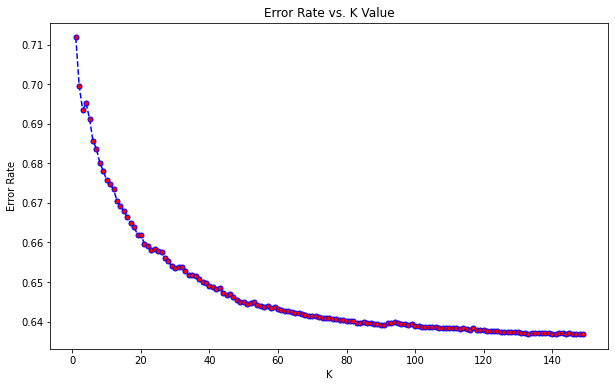

In [40]:
#Plotting the graph for error rate vs k value
plt.figure(figsize=(10,6))
plt.plot(range(1,150),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=5)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

As we can see in the graph, most optimum value of k that we can choose is 147 as it is at the global minima of the curve.

## Model-2: Using Decision Tree
Here we will apply and chck the accuracy of Decision trees

In [42]:
# Decision Tree Model
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=4)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [43]:
#Getting the mean accuracy for test sets
dtree.score(X_test,y_test)

0.4487320837927233

In [44]:
#Getting the mean accuracy for training set
dtree.score(X_train,y_train)

0.4315905540751631

In [45]:
#Getting the F1-score
f1_score(y_test, y_pred, average='micro')

0.364571848585079

##Model-3: Using Random Forest Classifier
As usual we'll first create the model then test its accuracy.

In [46]:
# Random Forest Model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train.ravel())
y_pred = rfc.predict(X_test)

In [47]:
#Getting the accuracy for test sets
print("Accuracy = ",accuracy_score(y_test,y_pred))
print("F Score:", f1_score(y_test, y_pred, average='micro'))

Accuracy =  0.44027930907754503
F Score: 0.44027930907754503


# Choosing the best model
We can see from the mean accuracy scores that decision tree and random forest are equally accurate. So, we choose to go with Random Forest classifier

In [48]:
# save the model to disk
joblib.dump(rfc, "./random_forest_model.joblib", compress=True)
joblib.dump(encoders, "./encoders.joblib", compress=True)
files.download("random_forest_model.joblib")
files.download("encoders.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Testing

In [49]:
#Ready to predict
prediction = rfc.predict(X_TEST) # Random Forest Model
prediction = pd.DataFrame({'PREDICTED_OFFENSE_GROUP': prediction})
testdata = testdata.reset_index()
testdata['index']=testdata['index'].astype(int)
prediction = prediction.reset_index()
prediction['index']=prediction['index'].astype(int)


In [50]:
final_result = pd.merge(left=testdata, right=prediction, left_on='index', right_on='index')
final_result.drop(['index'], axis=1, inplace = True)

In [51]:
final_result.head(50)

,Day,Month,Year,Hour,DAY_OF_YEAR,WEEK_OF_YEAR,Lat,Long,OFFENSE_DESCRIPTION,PREDICTED_OFFENSE_GROUP
0,10,3,2020,11,70,11,42.306480,-71.066757,Larceny,2
1,6,7,2020,9,188,28,42.359132,-71.070743,Larceny,2
2,3,7,2020,14,185,27,42.363565,-71.064493,Assault,0
3,24,6,2020,12,176,26,42.356800,-71.058930,Larceny,0
4,1,4,2020,11,92,14,42.287093,-71.148221,Assault,2
5,16,1,2020,16,16,3,42.309764,-71.115412,Robbery,2
6,25,3,2020,22,85,13,42.304339,-71.084778,Assault,0
7,24,4,2020,9,115,17,42.248865,-71.131222,Robbery,2
8,15,6,2020,13,167,25,42.337358,-71.078042,Assault,0
9,5,6,2020,17,157,23,42.286240,-71.064168,Robbery,0


In [52]:
final_result['PREDICTED_OFFENSE_GROUP'] = pd.DataFrame(categorical_convert.inverse_transform(final_result['PREDICTED_OFFENSE_GROUP']))
final_result.head(50)

,Day,Month,Year,Hour,DAY_OF_YEAR,WEEK_OF_YEAR,Lat,Long,OFFENSE_DESCRIPTION,PREDICTED_OFFENSE_GROUP
0,10,3,2020,11,70,11,42.306480,-71.066757,Larceny,Larceny
1,6,7,2020,9,188,28,42.359132,-71.070743,Larceny,Larceny
2,3,7,2020,14,185,27,42.363565,-71.064493,Assault,Assault
3,24,6,2020,12,176,26,42.356800,-71.058930,Larceny,Assault
4,1,4,2020,11,92,14,42.287093,-71.148221,Assault,Larceny
5,16,1,2020,16,16,3,42.309764,-71.115412,Robbery,Larceny
6,25,3,2020,22,85,13,42.304339,-71.084778,Assault,Assault
7,24,4,2020,9,115,17,42.248865,-71.131222,Robbery,Larceny
8,15,6,2020,13,167,25,42.337358,-71.078042,Assault,Assault
9,5,6,2020,17,157,23,42.286240,-71.064168,Robbery,Assault
